In [1]:
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
def print_image(image):
  fig, ax = plt.subplots()
  ax.imshow(image)
  ax.axis('off')
  plt.show()

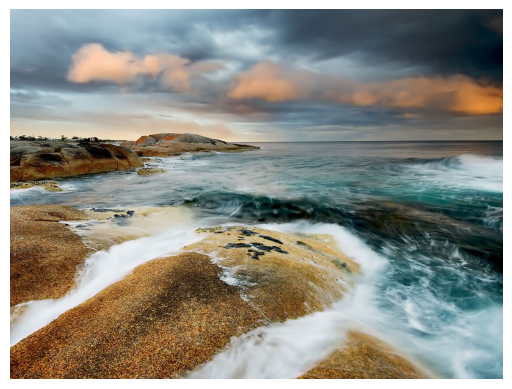

In [47]:
img=plt.imread('photo.jpg')
print_image(img)

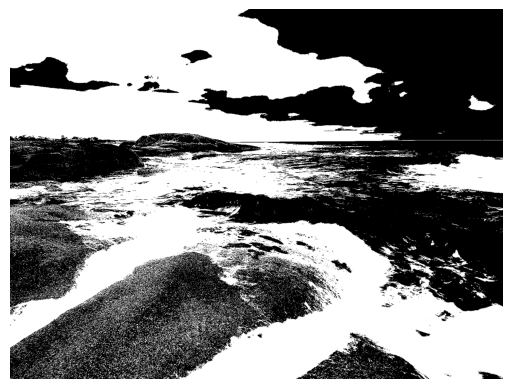

In [52]:
@cuda.jit
def binarize_img(src, dst, threshold):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  if tidx < src.shape[0] and tidy < src.shape[1]:
        g = np.uint8((src[tidx, tidy, 0] + src[tidx, tidy, 1] + src[tidx, tidy, 2]) / 3)
        if g > threshold:
            g = 255
        else:
            g = 0
        dst[tidx, tidy, 0] = g
        dst[tidx, tidy, 1] = g
        dst[tidx, tidy, 2] = g

imageHeight, imageWidth, _ = img.shape
devSrc = cuda.to_device(img)
devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)

# Define block and grid size
threads_per_block = (32, 32)
blocks_per_grid_x = (img.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (img.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

binarize_img[blocks_per_grid, threads_per_block](devSrc, devDst, 128)

hostDst = devDst.copy_to_host()
binarize_img = hostDst.reshape((imageHeight, imageWidth, 3))

print_image(binarize_img)

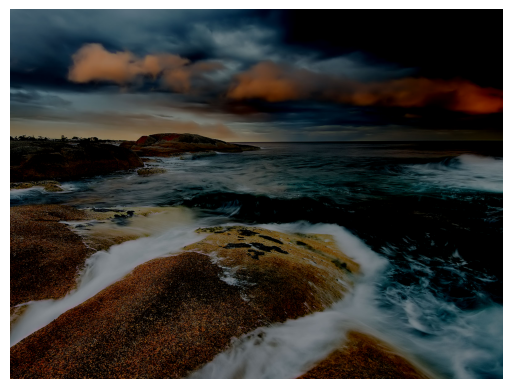

In [58]:
@cuda.jit
def adjust_brightness(src, dst, brightness):
    # Calculate thread (x, y) index for 2D grid
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx < src.shape[0] and tidy < src.shape[1]:
        for c in range(3):
            new_value = src[tidx, tidy, c] + brightness
            dst[tidx, tidy, c] = min(max(new_value, 0), 255)

# Set the brightness adjustment value
brightness_value = -100

imageHeight, imageWidth, _ = img.shape
devSrc = cuda.to_device(img)
devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)

adjust_brightness[blocks_per_grid, threads_per_block](devSrc, devDst, brightness_value)

hostDst = devDst.copy_to_host()
bright_img = hostDst.reshape((imageHeight, imageWidth, 3))

print_image(bright_img)

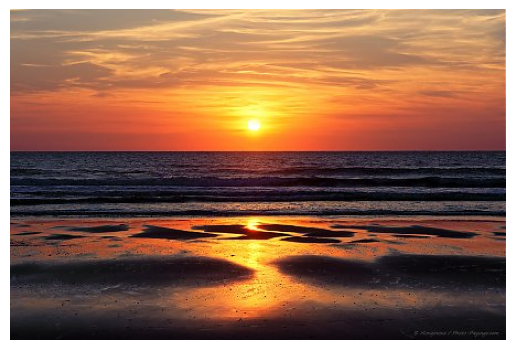

In [59]:
img2=plt.imread('photoblur.jpg')
print_image(img2)

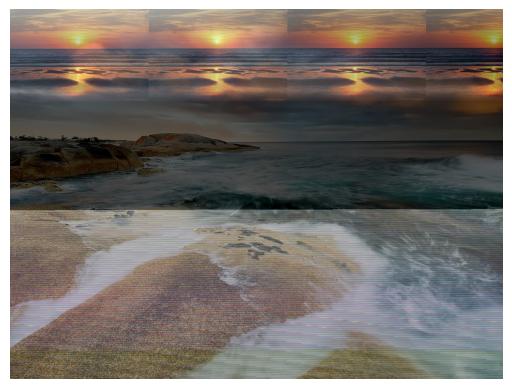

In [63]:
@cuda.jit
def blend_images(src1, src2, dst, alpha):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx < src1.shape[0] and tidy < src1.shape[1]:
        for c in range(3):  # Loop over R, G, B channels
            blended_value = alpha * src1[tidx, tidy, c] + (1 - alpha) * src2[tidx, tidy, c]
            dst[tidx, tidy, c] = min(max(int(blended_value), 0), 255)


alpha_value = 0.4

imageHeight, imageWidth, _ = img.shape
devSrc1 = cuda.to_device(img)
devSrc2 = cuda.to_device(img2)
devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)

blend_images[blocks_per_grid, threads_per_block](devSrc1, devSrc2, devDst, alpha_value)

hostDst = devDst.copy_to_host()
blend_img = hostDst.reshape((imageHeight, imageWidth, 3))

print_image(blend_img)